# CAB420 Assignment 1B Question 1: Template and Utilities Demo

## Overview

This notebook provides a quick demo and overview of the provided utility functions to help with Assignment 1B, Question 1.

Please make sure you read the assignment brief on canvas, and check the FAQ for other information.

**Note: File paths used in this template may need to change for your local machine. Please set these based on your local file system structure.**

## Utility Functions

The following cell contains utility functions to:
* Load the data
* Vectorise the data
* Plot images
* Resize all images
* Convert images to grayscale
* Build pairs or triplets of images for metric learning networks
* Plot a CMC Curve

These are provided to assist you in developing your solution.

In [35]:
#
# Utility functions for CAB420, Assignment 1B, Q1
# Author: Simon Denman (s.denman@qut.edu.au)
#
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import cv2                          # for image loading and colour conversion
import tensorflow as tf             # for bulk image resize
import glob
import random
import keras

# get the subject ID from the filename. A sample filename is 0001_c1s1_001051_00.jpg, the first
# four characters are the subject ID
#   fn:      the filename to parse
# 
#   returns: first four characters of the filename converted to an int
#
def get_subject_id_from_filename(fn):
    return int(fn[0:4])

# load the images in a directory
#   base_path: path to the data
#
#   returns:   numpy arrays of size (samples, width, height, channels), and size (samples) for 
#              images and thier labels
def load_directory(base_path):

    # find all images in the directory
    files = glob.glob(os.path.join(base_path, '*.jpg'))
    x = []
    y = []
    
    # loop through the images, loading them and extracting the subject ID
    for f in files:
        x.append(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0)
        y.append(get_subject_id_from_filename(os.path.basename(f)))
        
    return np.array(x), np.array(y)

# load the data
#   base_path: path to the data, within the directory that this points to there should be a 'Training' 
#              and 'Testing' directory
#
#   returns:   loaded data
#
def load_data(base_path):
    
    # load training data
    train_X, train_Y = load_directory(os.path.join(base_path, 'Training'))

    # load gallery data from the test set
    gallery_X, gallery_Y = load_directory(os.path.join(base_path, 'Testing', 'Gallery'))

    # load probe data from the test set
    probe_X, probe_Y = load_directory(os.path.join(base_path, 'Testing', 'Probe'))
    
    return train_X, train_Y, gallery_X, gallery_Y, probe_X, probe_Y

# Plot some images and their labels. Will plot the first 50 samples in a 10x5 grid
#  x: array of images, of shape (samples, width, height, channels)
#  y: labels of the images
#
def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1)
        ax.imshow(x[i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title(y[i])
        ax.axis('off')
        
# vectorise an array of images, such that the shape is changed from {samples, width, height, channels} to
# (samples, width * height * channels)
#   images: array of images to vectorise
#
#   returns: vectorised array of images
#
def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])

# Resize an array of images
#  images:   array of images, of shape (samples, width, height, channels)
#  new_size: tuple of the new size, (new_width, new_height)
#
#  returns:  resized array of images, (samples, new_width, new_height, channels)
#
def resize(images, new_size):
    # tensorflow has an image resize funtion that can do this in bulk
    # note the conversion back to numpy after the resize
    return tf.image.resize(images, new_size).numpy()
          
# Convert images to grayscale
#   images:  array of colour images to convert, of size (samples, width, height, 3)
#
#   returns: array of converted images, of size (samples, width, height, 1)
#
def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(images[i,:], cv2.COLOR_RGB2GRAY))
    # pack converted list as an array and return
    return np.expand_dims(np.array(gray), axis = -1)

# Create a batch of siamese data. Pairs will be evenly balanced, such that there is an
# equal number of positive and negative pairs
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate 
#
#   returns:    image pairs and labels to indicate if the pairs are the same, or different
#
def get_siamese_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label
        
# Plot the first 10 pairs of a batch, good sanity check for pair generation
#  x: images in the pairs
#  y: labels of the pairs
#
def plot_pairs(x, y):
    fig = plt.figure(figsize=[25, 6])
    for i in range(10):
        ax = fig.add_subplot(2, 10, i*2 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

        ax = fig.add_subplot(2, 10, i*2 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
        
# Create a batch of triplet data.
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of triplets to generate 
#
#   returns:    triplet of the requested batch size
#
def get_triplet_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_c = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

# Plot the first 9 triplets of a batch, good sanity check for triplet generation
#  x: images in the triplets
#
def plot_triplets(x):
    fig = plt.figure(figsize=[25, 10])
    for i in range(9):
        ax = fig.add_subplot(3, 9, i*3 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Triple ' + str(i) + ': Anchor')

        ax = fig.add_subplot(3, 9, i*3 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Positive')

        ax = fig.add_subplot(3, 9, i*3 + 3)
        ax.imshow(x[2][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Negative')

        
# Compute a ranked histogram, which can be used to generate a CMC curve. This function will loop 
# through all probe samples. For each probe sample it will:
#  - Compare the sample to all gallery samples to get a distance between the probe sample and 
#    all gallery samples. In this case it is the L1 distance
#  - Sort the gallery samples by how close they are to the probe samples
#  - Find the location of the true match
#  - Update a ranked histogram based on this
# The ranked histogram will show how many samples are matched at each rank. For example,
# ranked_histogram[0] will record how many samples are matched at Rank-1. 
#
# This implementation assumes that there is only one sample per ID in the gallery set
#
# NOTE: L1 distance, used here, may not be appropriate for all problems. Consider the nature
# of your problem and what distance measure you should use
#
#   gallery_feat: features for the gallery data, of shape (gallery_samples, num_features)
#   gallery_Y:    IDs of the gallery samples, of shape (gallery_samples,)
#   probe_feat:   features for the probe data, of shape (probe_samples, num_features)
#   probe_Y:      IDs of the probe samples, of shape (probe_samples,)
#   verbose:      bool to indicate if debug information shoudl be printed. Be careful using this with 
#                 large feature sets, and/or lots of samples
#   
#   returns:      ranked histogram matching the probe samples to the gallery
#
def get_ranked_histogram_l1_distance(gallery_feat, gallery_Y, probe_feat, probe_Y, verbose = False):
    
    # storage for ranked histogram
    # length equal to number of unique subjects in the gallery
    ranked_histogram = np.zeros(len(np.unique(gallery_Y)))

    # loop over all samples in the probe set
    for i in range(len(probe_Y)):
        # get the true ID of this sample
        true_ID = probe_Y[i]
        if verbose:
            print('Searching for ID %d' % (true_ID))

        # get the distance between the current probe and the whole gallery, L1 distance here. Note that L1
        # may not always be the best choice, so consider your distance metric given your problem
        dist = np.linalg.norm(gallery_feat - probe_feat[i,:], axis=1, ord=1)
        if verbose:
            print(dist)

        # get the sorted order of the distances
        a = np.argsort(dist)
        # apply the order to the gallery IDs, such that the first ID in the list is the closest, the second
        # ID is the second closest, and so on
        ranked = gallery_Y[a]
        if verbose:
            print('Ranked IDs for query:')
            print(a)

        # find the location of the True Match in the ranked list
        ranked_result = np.where(ranked == true_ID)[0][0]
        if verbose:
            print(ranked_result)

        # store the ranking result in the histogram
        ranked_histogram[ranked_result] += 1
        if verbose:
            print('')
    
    if verbose:
        print(ranked_histogram)
    
    return ranked_histogram

# Convert a ranked histogram to a CMC. This simply involves computing the cumulative sum over the histogram
# and dividing it by the length of the histogram
#   ranked_hist: ranked histogram to convert to a CMC
#
#   returns:     CMC curve
#
def ranked_hist_to_CMC(ranked_hist):

    cmc = np.zeros(len(ranked_hist))
    for i in range(len(ranked_hist)):
        cmc[i] = np.sum(ranked_hist[:(i + 1)])
    
    return (cmc / len(ranked_hist))

# plot a CMC
#   cmc: cmc data to plot
#
def plot_cmc(cmc):
    fig = plt.figure(figsize=[10, 8])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(1, len(cmc)+1), cmc)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Count')
    ax.set_ylim([0, 1.0])
    ax.set_title('CMC Curve')      

## Utility Function Demonstration

The following presents a brief demonstration of the utility functions. These portions of code do not form part of the template, or solution, and could be commented out/removed, or you could restructure this portion of the code to form part of your solution.

### Data Loading

This will load the data, pulling out the training set, and gallery and probe testing sets.

(5933, 128, 64, 3)
(5933,)
(301, 128, 64, 3)
(301,)
(301, 128, 64, 3)
(301,)


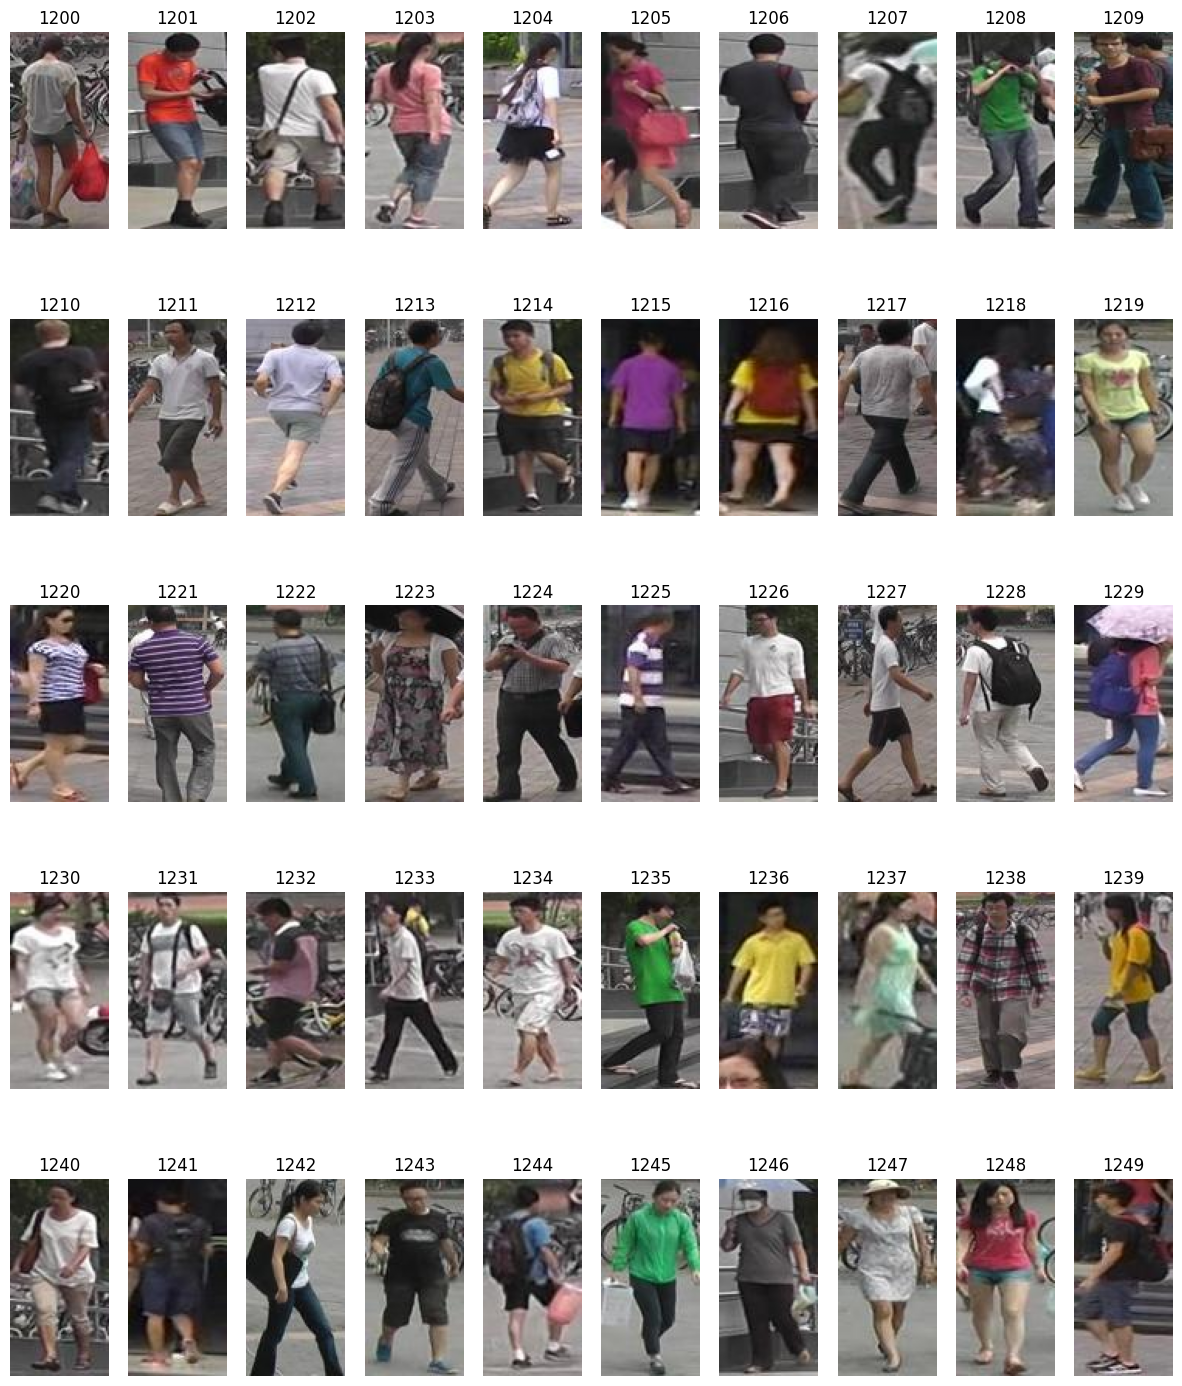

In [2]:
# note that you will probably need to change the filepath here
train_X, train_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('Data/Q1/')
print(train_X.shape)
print(train_Y.shape)
print(gallery_X.shape)
print(gallery_Y.shape)
print(probe_X.shape)
print(probe_Y.shape)

# plot some images
plot_images(gallery_X, gallery_Y)

### Pair and Triplet Data

Pair and triplet functions are provided to pull out paired and triplet data for use with Siamese networks.

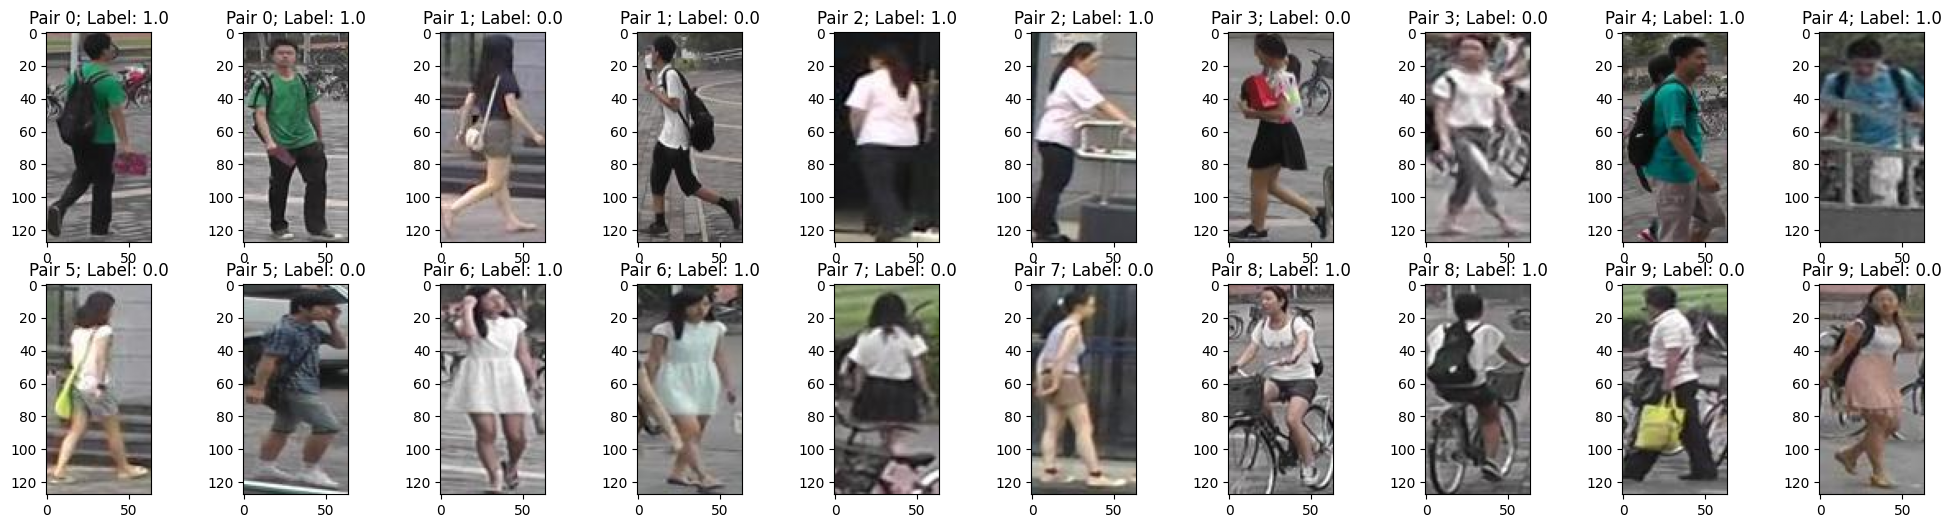

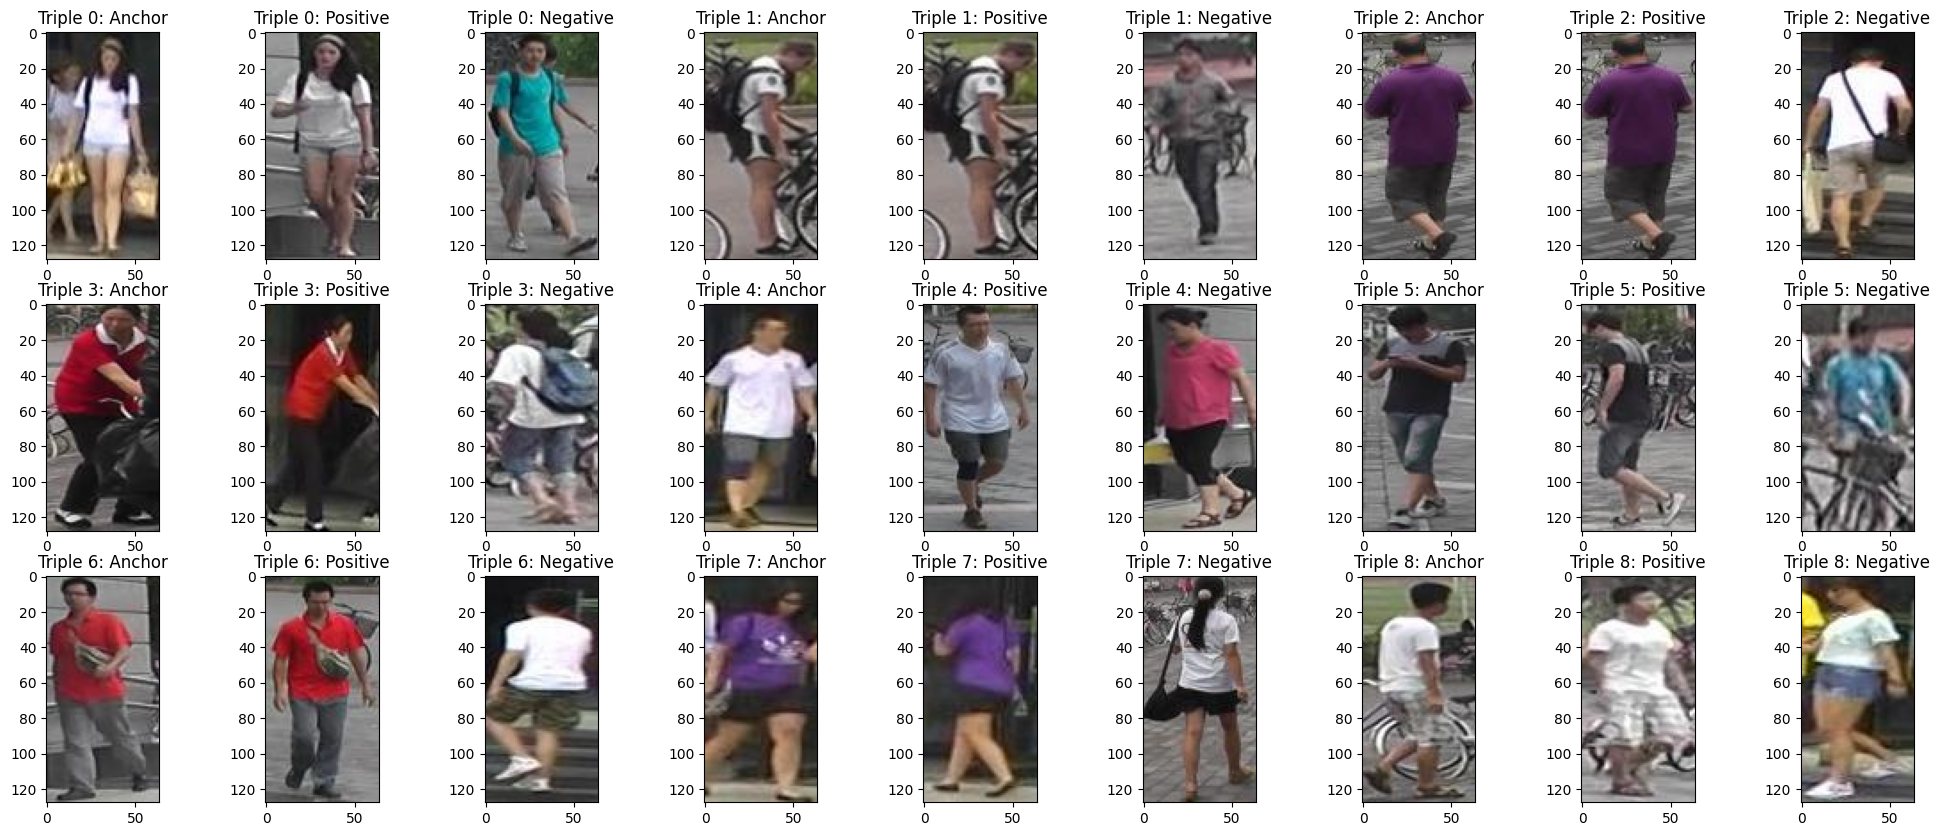

In [3]:
# create a pair generator and display a pair
x, y = get_siamese_data(train_X, train_Y, 10)
plot_pairs(x, y)

# create a triplet and display a triplet
x = get_triplet_data(train_X, train_Y, 9)
plot_triplets(x)

### Conversion and Resizing

Functions to convert images to greyscale and resize them are also provided.

(301, 64, 32, 1)
(301, 64, 32, 1)


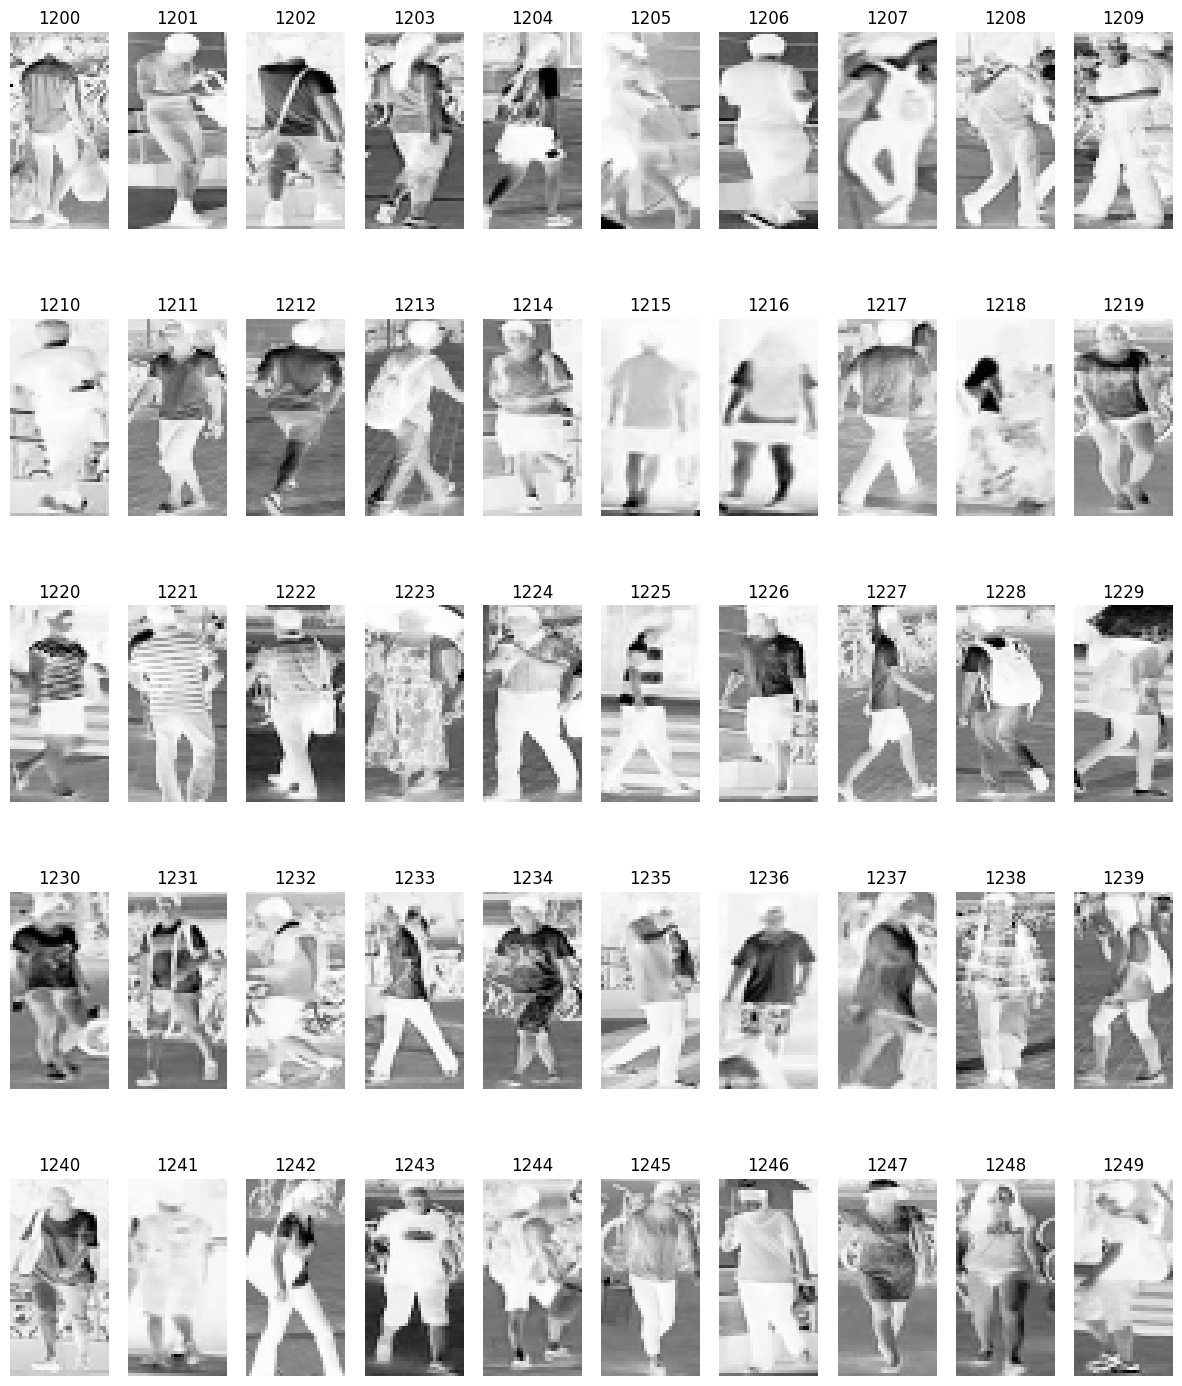

In [4]:
# resize data and convert to grayscale
gallery_X_small_gray = convert_to_grayscale(resize(gallery_X, (64, 32)))
print(gallery_X_small_gray.shape)
probe_X_small_gray = convert_to_grayscale(resize(probe_X, (64, 32)))
print(probe_X_small_gray.shape)

# plot some resized and grayscale images
plot_images(gallery_X_small_gray, gallery_Y)

### Vectorising Data

To use the images with non-DL methods, they need to be vectorised. A function is provided for this.

In [5]:
# vectorise some data
gallery_feat_vec = vectorise(gallery_X_small_gray)
probe_feat_vec = vectorise(probe_X_small_gray)
print(gallery_feat_vec.shape)
print(probe_feat_vec.shape)

#
# at this point, you have data in the shape (gallery_samples, number_of_features) and (probe_samples, number_of_features)
#

(301, 2048)
(301, 2048)


### CMC Curves

Functions to create a CMC curve are provided. These assume that you have data in the following form:
* An array of gallery features, of size (gallery_samples, num_features)
* An array of gallery IDs, of size (gallery_samples)
* An array of probe features, of size (probe_samples, num_features)
* An array of probe IDs, of size (probe_samples)

Note that the provided implementation is limited in that it assumes that you have only one sample from each gallery ID in the set of gallery samples.

The process of generating a CMC is split across three functions:
* ``get_ranked_histogram_l1_distance``, which will compare each probe sample to all gallery samples and determine the location of the correct match (the rank), storing this in a histogram
* ``ranked_hist_to_CMC``, which will convert the ranked histogram to a CMC
* ``plot_cmc``, which will actually plot the CMC

Two simple examples demonstrating this are given below.

[0 1 2 3 4 5 6 7]
[[ 0.73626868 -1.88699801]
 [-0.19896844  2.82061098]
 [ 0.24504291  2.94781992]
 [ 4.46104359  1.1148621 ]
 [ 3.85886622  4.87283516]
 [ 4.52844489  3.3484366 ]
 [ 4.7016287   7.16723709]
 [ 6.83607559  7.24287684]]
(8, 2)
[0 1 2 3 4 5 6 7]
[[ 1.24049509 -0.33071997]
 [ 0.13312662  1.7860494 ]
 [ 1.04389436  0.81525903]
 [ 3.62930285  3.20959807]
 [ 7.27392676  7.11783429]
 [ 6.8703917   8.81132047]
 [ 2.62109963  5.80417784]
 [ 5.33097841  4.84204029]]
(8, 2)
Searching for ID 0
[ 2.06050445  4.59079448  4.27399207  4.66613057  7.82192625  6.96710636
 10.95909066 13.1691773 ]
Ranked IDs for query:
[0 2 1 3 5 4 6 7]
0

Searching for ID 1
[ 4.27618947  1.36665664  1.27368681  4.99910427  6.81252536  5.95770547
  9.94968977 12.15977641]
Ranked IDs for query:
[2 1 0 3 5 4 6 7]
1

Searching for ID 2
[ 3.00988271  3.24821475  2.93141234  3.71675231  6.87254799  6.0177281
 10.0097124  12.21979904]
Ranked IDs for query:
[2 0 1 3 5 4 6 7]
0

Searching for ID 3
[7.98963025 4.2

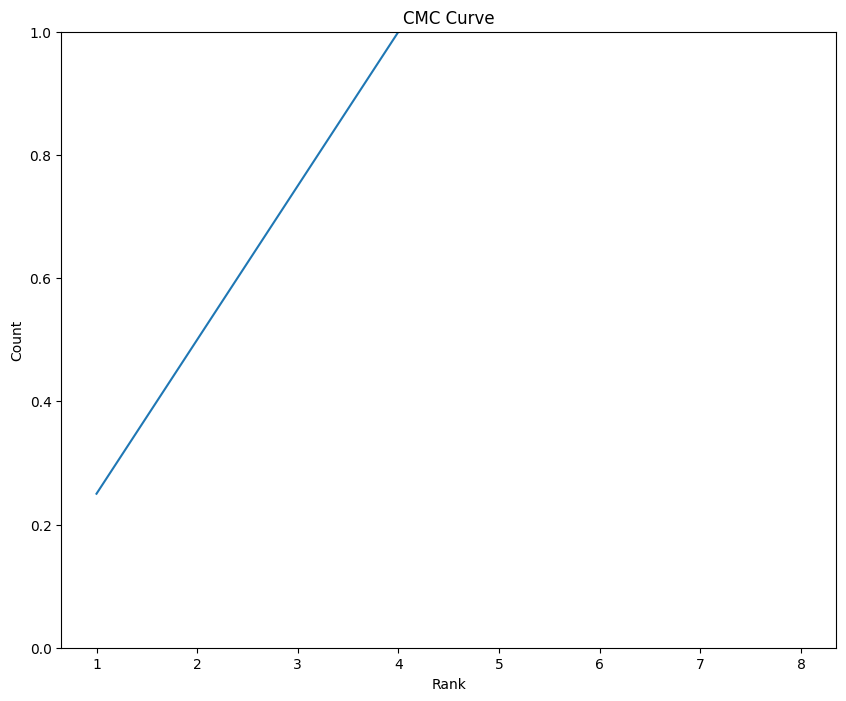

In [6]:
#CMC CURVE EXAMPLE CODE
# we'll start off with just 8 IDs
num_ids = 8

# we'll create a list of IDs, these are the gallery and probe IDs (gallery_y and probe_y)
ID_1 = np.arange(0, num_ids, 1)
ID_2 = np.arange(0, num_ids, 1)
# we'll then generate some features
# to keep this simple, we'll use a 2D feature, i.e. each sample will have a 2D feature associated with it
# this means that we have our gallery features of size (8, 2), as we have 8 samples and 2D feaures
Feat_1 = np.transpose(np.vstack([ID_1, ID_1]) + (np.random.rand(2, num_ids) - 0.5)*4.0, (1,0))
Feat_2 = np.transpose(np.vstack([ID_2, ID_2]) + (np.random.rand(2, num_ids) - 0.5)*8.0, (1,0))

# print features and their shape to confirm what we have
print(ID_1)
print(Feat_1)
print(Feat_1.shape)
print(ID_2)
print(Feat_2)
print(Feat_2.shape)

# we can now compute the ranked histogram
# this will print out of a heap of debug data to show what's going on. In particular we see the distance between
# each probe sample and the whole gallery, and the rank of the true match, which is what is used to build the 
# ranked histogram
ranked_hist = get_ranked_histogram_l1_distance(Feat_1, ID_1, Feat_2, ID_2, True)
#print(ranked_hist)
cmc = ranked_hist_to_CMC(ranked_hist)
print(cmc)
plot_cmc(cmc)

The above example results in a pretty simple CMC. Let's throw more IDs at it to get something that looks a bit better. The setup here is the same as what's above, we just have 100 gallery and probe samples now instead.

(100, 2)
(100, 2)


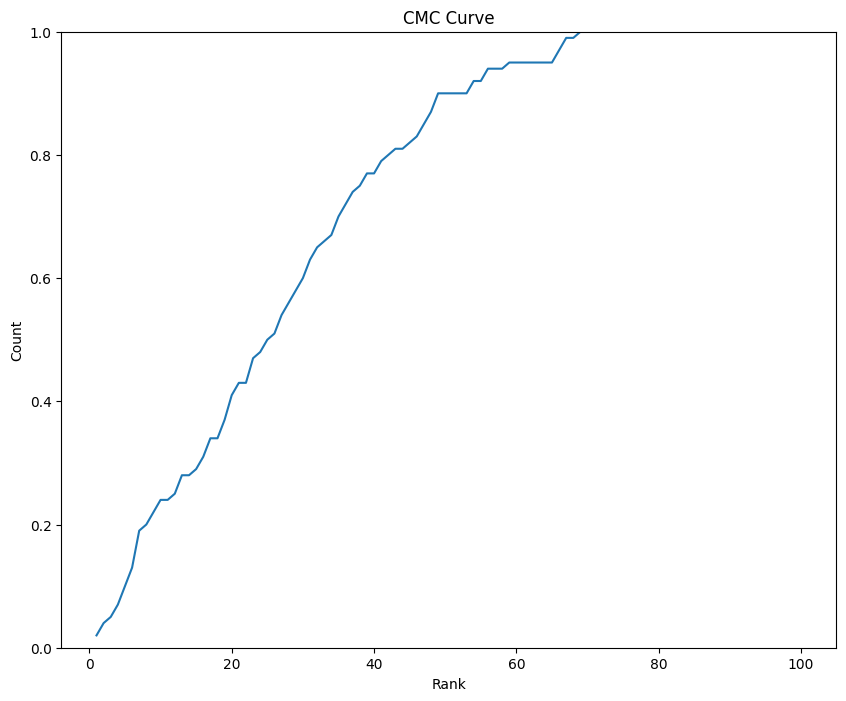

In [7]:
num_ids = 100

ID_1 = np.arange(0, num_ids, 1)
ID_2 = np.arange(0, num_ids, 1)
Feat_1 = np.transpose(np.vstack([ID_1, ID_1]) + (np.random.rand(2, num_ids) - 0.5)*20.0, (1,0))
Feat_2 = np.transpose(np.vstack([ID_2, ID_2]) + (np.random.rand(2, num_ids) - 0.5)*80.0, (1,0))
print(Feat_1.shape)
print(Feat_2.shape)

ranked_hist = get_ranked_histogram_l1_distance(Feat_1, ID_1, Feat_2, ID_2)
cmc = ranked_hist_to_CMC(ranked_hist)
plot_cmc(cmc)

With a CMC, the ideal curve is one that is always at 100%. The steeper the curve and faster it get's to 100%, the better.

## Question 1 Template

The following provides a starting point for your solution, and some suggestions on how to proceed.

In [8]:
#
# Task Overview
#
# This question concerns person re-identification. We can think of this as a retrieval problem, where the input is an image
# and the output is a list of people, ranked based on how similar they are to the image. To get this similarity-based
# ranking, we need a way to compare two images and measure their similarity. To do this you will use a learned representation.
# The question asks you to train two models (one non-DL, one DL) to extract such a representation of an image. Using this
# learned representation, you can then transform a pair of images into vectors, and the distance between the vectors is a 
# measure of their similarity.
#
# The data you have been given is split into three: training, gallery and probe. This is NOT the same as training, validation 
# and test. Within the training set, you have roughly 2-20 images of 300 different people. You will use this data to train
# your model. The gallery and probe each contain one image for 301 individuals. The gallery and probe both contain the same
# 301 individuals. This is your test set. When thinking about this set, consider the re-ID problem. The gallery set contains
# images of 301 people that have been seen on some CCTV network. The probe set represents images that you are trying to match
# to those in the gallery set.
#
# If you want a validation set, there are two possible approaches:
# - Split the training set based on IDs. Perhaps have ~250 IDs in the training set and ~50 IDs in the validation set. This approach
#   replicates the test set (the combined gallery and probe sets) in that you have disjoint IDs for training and validation.
# - Split the training data randomly, using a roughly 80/20 split. If you take this approach, note that some IDs have very few
#   samples, so care many need to be taken
# Note also that it is not required to use a validation set. How you proceed is up to you.
#

In [9]:
from sklearn import discriminant_analysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
#
# Data loading and Pre-processing
#

# Load the data
# Change the path to whatever is appropriate on your system
train_X, train_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('Data/Q1/')

train_X_col = convert_to_grayscale(resize(train_X, (64, 32)))
gallery_X_col = convert_to_grayscale(resize(gallery_X, (64, 32)))
probe_X_col = convert_to_grayscale(resize(probe_X, (64, 32)))

# Randomly split the data into training and validation sets
train_X_col_split, val_X_col, train_Y_split, val_Y = train_test_split(train_X_col, train_Y, test_size=0.2, random_state=42)

# Print shapes to verify
print("Training set shapes:")
print(train_X_col_split.shape)
print(train_Y_split.shape)
print("\nValidation set shapes:")
print(val_X_col.shape)
print(val_Y.shape)

train_X_vec = vectorise(train_X_col_split)
val_X_vec = vectorise(val_X_col)
gallery_X_vec = vectorise(gallery_X_col)
probe_X_vec = vectorise(probe_X_col)

# Standardise the data
scaler = StandardScaler()
train_X_vec = scaler.fit_transform(train_X_vec)
val_X_vec = scaler.transform(val_X_vec)
gallery_X_vec = scaler.transform(gallery_X_vec)
probe_X_vec = scaler.transform(probe_X_vec)

print(train_X_vec.shape)
print(val_X_vec)
print(gallery_X_vec.shape)
print(probe_X_vec.shape)
print(train_X_col_split.shape)
print(train_Y.shape)

Training set shapes:
(4746, 64, 32, 1)
(4746,)

Validation set shapes:
(1187, 64, 32, 1)
(1187,)
(4746, 2048)
[[-0.45326927 -0.46456373 -0.5070655  ... -0.7820048  -0.8976039
  -0.81317896]
 [ 0.95057034  1.0353744   1.0780282  ... -1.2253425  -1.2843624
  -1.4522249 ]
 [ 0.56268984  0.8673799   0.99284565 ... -0.11693893 -0.2506996
  -0.55265343]
 ...
 [-1.5133785  -1.5043546  -1.5035949  ...  0.8711249   1.0523168
   1.4215615 ]
 [-1.1374874  -1.060017   -1.009487   ... -2.570419   -2.6226428
  -2.6244094 ]
 [-0.08991034 -0.40682018 -0.5381519  ... -0.22155625 -0.4474187
  -0.48339865]]
(301, 2048)
(301, 2048)
(4746, 64, 32, 1)
(5933,)


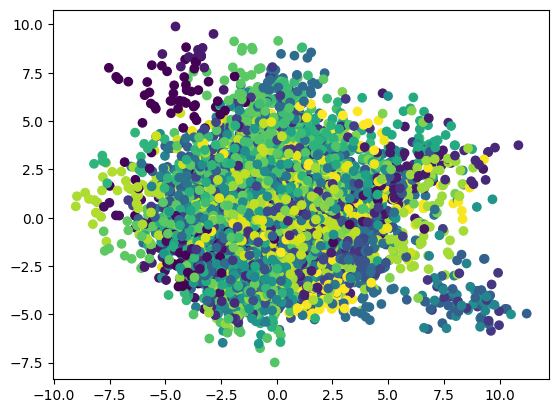

In [10]:
# 
# Non-DL Method
#
# Using the vectorised data, develop your non-DL method. A suggested approach would be:
# - Train a PCA, LDA, or both PDA and LDA subspace using the training data. Note that you will need to select the method(s), 
#   and choose any key parameters (for example, if you use PCA how many components you retain)
# - Using the trained subspace, project the gallery and probe data.
#

def apply_lda(train_X, train_Y):
    lda = discriminant_analysis.LinearDiscriminantAnalysis()
    lda.fit(train_X, train_Y)
    transformed_data = lda.transform(train_X)
    return transformed_data, lda

# Apply LDA to the training data
transformed_train_data, lda_model = apply_lda(train_X_vec, train_Y_split)

# Use the fitted LDA model to transform the gallery and probe data
transformed_gallery_data = lda_model.transform(gallery_X_vec)
transformed_probe_data = lda_model.transform(probe_X_vec)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(transformed_train_data[:,0], transformed_train_data[:,1], c=train_Y_split)


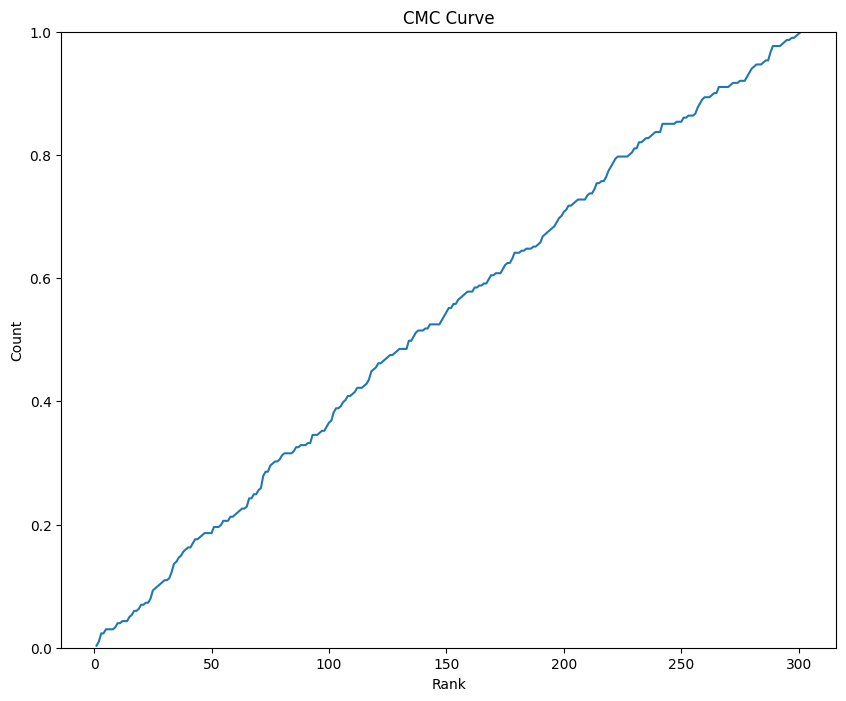

In [11]:
# Compute similarity scores using Euclidean distance
similarity_scores = -np.linalg.norm(transformed_gallery_data[:, np.newaxis, :] - transformed_probe_data, axis=2)

# Compute ranked histogram and CMC curve
ranked_histogram = get_ranked_histogram_l1_distance(transformed_gallery_data, gallery_Y, transformed_probe_data, probe_Y)
cmc_curve = ranked_hist_to_CMC(ranked_histogram)

# Plot the CMC curve
plot_cmc(cmc_curve)

Text(0.5, 0, 'Number of Components')

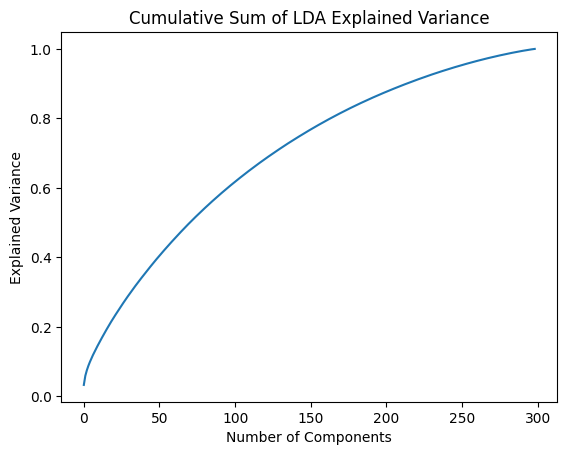

In [12]:
cumulative_sum = np.cumsum(lda_model.explained_variance_ratio_, axis=0)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(cumulative_sum)
ax.set_title('Cumulative Sum of LDA Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Number of Components')

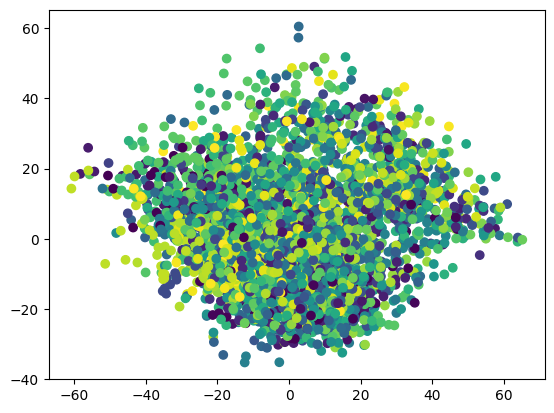

In [13]:
from sklearn.decomposition import PCA

def apply_pca(data):
    pca = PCA()
    transformed_data = pca.fit_transform(data)
    return transformed_data, pca

transformed_train_data, pca_model = apply_pca(train_X_vec)

# Use the fitted PCA model to transform the gallery and probe data
transformed_gallery_data_pca = pca_model.transform(gallery_X_vec)
transformed_probe_data_pca = pca_model.transform(probe_X_vec)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(transformed_train_data[:,0], transformed_train_data[:,1], c=train_Y_split)

Top-1 Accuracty: 0.023255813953488372
Top-2 Accuracty: 0.03322259136212625
Top-3 Accuracty: 0.04318936877076412
Top-4 Accuracty: 0.046511627906976744
Top-5 Accuracty: 0.053156146179401995
Top-6 Accuracty: 0.059800664451827246
Top-7 Accuracty: 0.06976744186046512
Top-8 Accuracty: 0.08637873754152824
Top-9 Accuracty: 0.09634551495016612
Top-10 Accuracty: 0.10963455149501661


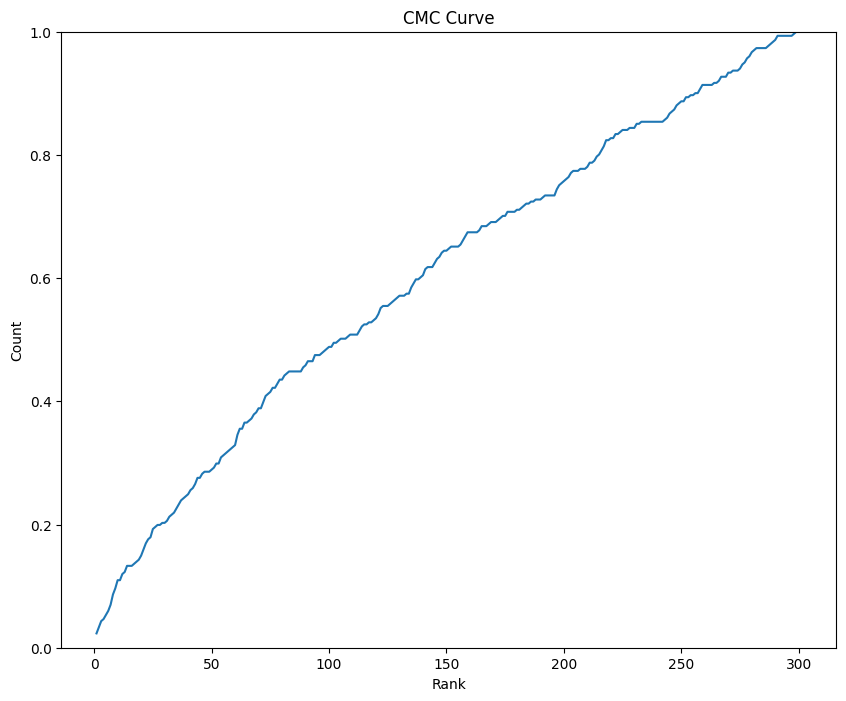

In [14]:
# Compute similarity scores between probe and gallery samples
similarity_scores_pca = -np.linalg.norm(transformed_gallery_data_pca[:, np.newaxis, :] - transformed_probe_data_pca, axis=2)

# Compute ranked histogram and CMC curve
ranked_histogram_pca = get_ranked_histogram_l1_distance(transformed_gallery_data_pca, gallery_Y, transformed_probe_data_pca, probe_Y)
cmc_curve_pca = ranked_hist_to_CMC(ranked_histogram_pca)

print("Top-1 Accuracty:",cmc_curve_pca[0]) 
print("Top-2 Accuracty:",cmc_curve_pca[1])
print("Top-3 Accuracty:",cmc_curve_pca[2])
print("Top-4 Accuracty:",cmc_curve_pca[3])
print("Top-5 Accuracty:",cmc_curve_pca[4])
print("Top-6 Accuracty:",cmc_curve_pca[5])
print("Top-7 Accuracty:",cmc_curve_pca[6])
print("Top-8 Accuracty:",cmc_curve_pca[7])
print("Top-9 Accuracty:",cmc_curve_pca[8])
print("Top-10 Accuracty:",cmc_curve_pca[9]) 

# Plot the CMC curve
plot_cmc(cmc_curve_pca)

Text(0.5, 0, 'Number of Components')

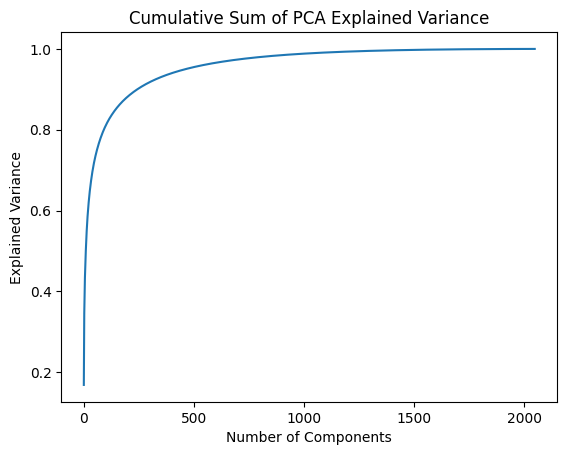

In [15]:
cumulative_sum = np.cumsum(pca_model.explained_variance_ratio_, axis=0)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(cumulative_sum)
ax.set_title('Cumulative Sum of PCA Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Number of Components')

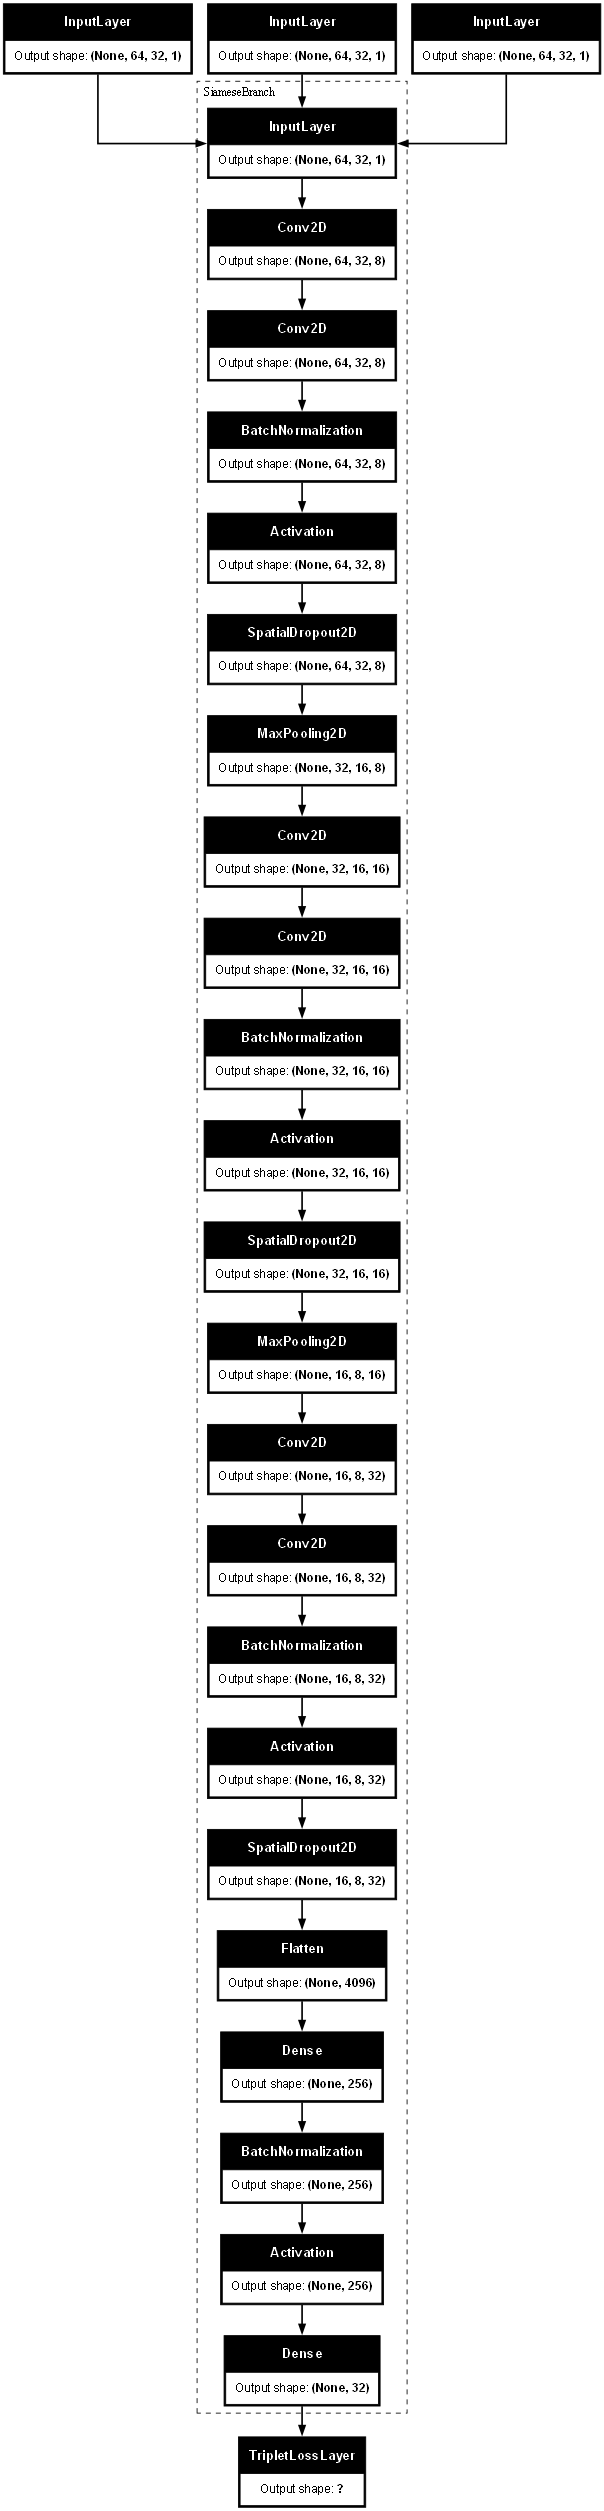

In [16]:
#
# DL Method
# 
# Using the image data, develop your DL method. A suggested approach would be:
#  - Pick a backbone for your network. This could be a network from the lecture or prac examples, or something from
#    keras.applications. As per Assignment 1A, the network does not need to be overly complex, but you should briefly explain 
#    your selection of this model. You should avoid networks so simple that they perform very badly.
#  - Pick your training approach. You have been given pair and triplet creation functions above, so you can easily use either contrastive
#    or a triplet loss. You could also look at the bonus example on hard negative mining and consider this approach. Once you've
#    picked your approach, set the network up with the correct number of inputs and an appropriate loss.
#  - Create some pairs and triplets, and train the network
#

def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):

    x = keras.layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = keras.layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = keras.layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = keras.layers.Dense(size, activation=None)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = keras.layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = keras.layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

embedding_size = 32
dummy_input = keras.Input((64, 32, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = keras.layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')

input_a = keras.Input((64, 32, 1), name='InputA')
input_b = keras.Input((64, 32, 1), name='InputB')

embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

def normalise_vector(vect):
    # get the magnitude for each vector in the batch
    mag = keras.ops.sqrt(keras.ops.sum(keras.ops.square(vect), axis=1))
    # repeat this, so we now have as many elements in mag as we do in vect
    mag = keras.ops.reshape(keras.ops.repeat(mag, vect.shape[1], axis=0), (-1, vect.shape[1]))
    # element wise division
    return keras.ops.divide(vect, mag)

class TripletLossLayer(keras.layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = normalise_vector(anchor)
        positive = normalise_vector(positive)
        negative = normalise_vector(negative)

        p_dist = keras.ops.sum(keras.ops.square(anchor-positive), axis=-1)
        n_dist = keras.ops.sum(keras.ops.square(anchor-negative), axis=-1)
        return keras.ops.sum(keras.ops.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
        
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
input_anchor = keras.Input((64, 32, 1), name='Anchor')
input_positive = keras.Input((64, 32, 1), name='Positive')
input_negative = keras.Input((64, 32, 1), name='Negative')
embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

margin = 1
loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')([embedding_anchor, embedding_positive, embedding_negative])

triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=loss_layer)
# as per previous example, if you want the full network set expand_nested=True
keras.utils.plot_model(triplet_network, show_shapes=True, dpi = 60, expand_nested=True)


In [17]:
batch_size = 128
triplet_network.compile(optimizer=keras.optimizers.Adam(), jit_compile=False)
triplet_train_x = get_triplet_data(train_X_col_split, train_Y_split, 15000)
triplet_test_x = get_triplet_data(val_X_col, val_Y, 3000)
triplet_network.fit(x=triplet_train_x, y=None, batch_size=batch_size, epochs=10, validation_data=(triplet_test_x, None))

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - loss: 77.6301 - val_loss: 44.0804
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - loss: 37.9924 - val_loss: 28.4737
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 24s 201ms/step - loss: 29.7583 - val_loss: 27.2605
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step - loss: 24.9019 - val_loss: 26.9245
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - loss: 21.4645 - val_loss: 25.1826
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - loss: 18.1565 - val_loss: 24.8491
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - loss: 16.0481 - val_loss: 23.7830
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - loss: 14.2217 - val_loss: 24.4445
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 187ms/step - loss: 12.0332 - val_loss: 23.5130
Epoch 10/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - loss: 10.3921 - val_loss: 24.5122


In [18]:
def match_gallery_probe_for_testing(gallery_X, gallery_Y, probe_X, probe_Y):
    matched_test_X = []
    matched_test_Y = []

    for probe_sample, probe_label in zip(probe_X, probe_Y):
        # Find the index of the matching sample in the gallery set
        matching_indices = np.where(gallery_Y == probe_label)[0]
        if len(matching_indices) > 0:
            # Choose the first matching sample from the gallery set
            matching_index = matching_indices[0]
            matched_test_X.append(probe_sample)
            matched_test_Y.append(gallery_Y[matching_index])

    return np.array(matched_test_X), np.array(matched_test_Y)

matched_test_X, matched_test_Y = match_gallery_probe_for_testing(gallery_X_col, gallery_Y, probe_X_col, probe_Y)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


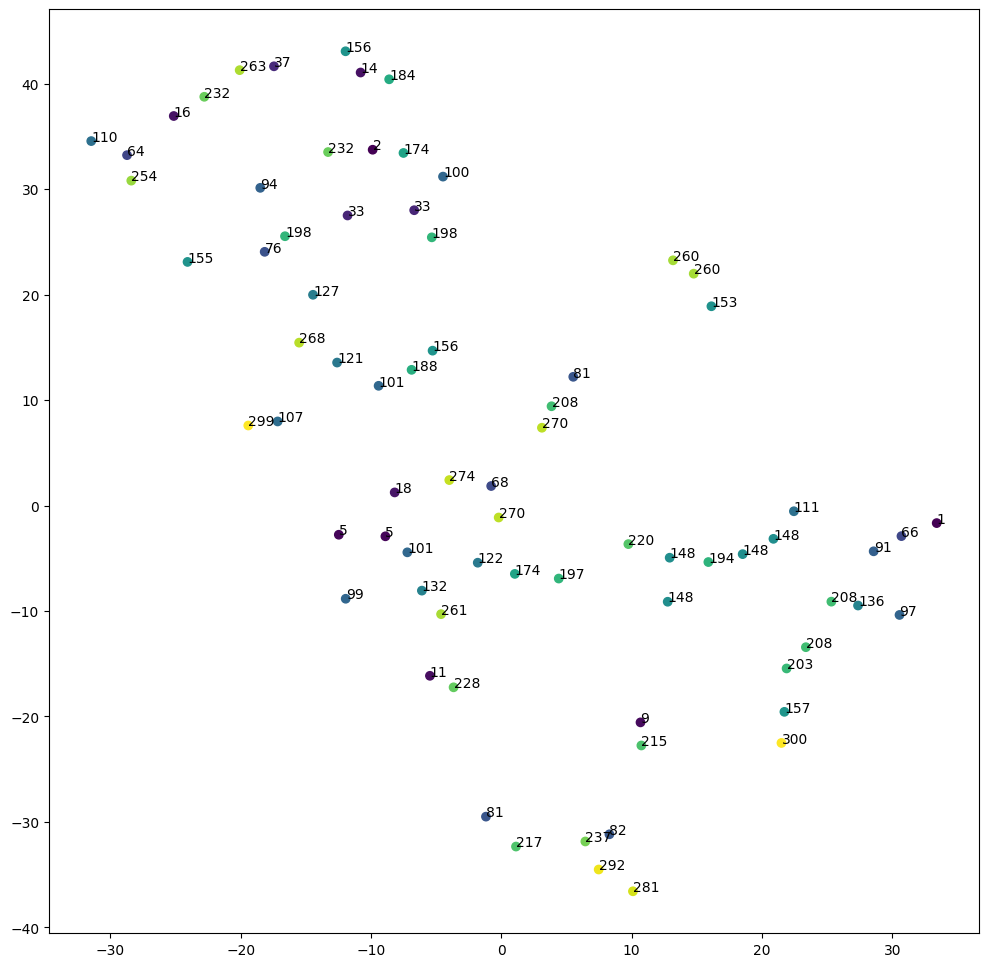

In [19]:
from sklearn.manifold import TSNE

embx = val_X_col[:75]
emby = val_Y[:75]

embeddings = base_network.predict(embx)
tsne_embeddings = TSNE(perplexity=5, random_state=5).fit_transform(embeddings)

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
scatter = ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=emby.flatten())

# Annotate each point with its index
for i, txt in enumerate(emby.flatten()):
    ax.annotate(txt, (tsne_embeddings[i, 0], tsne_embeddings[i, 1]))

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


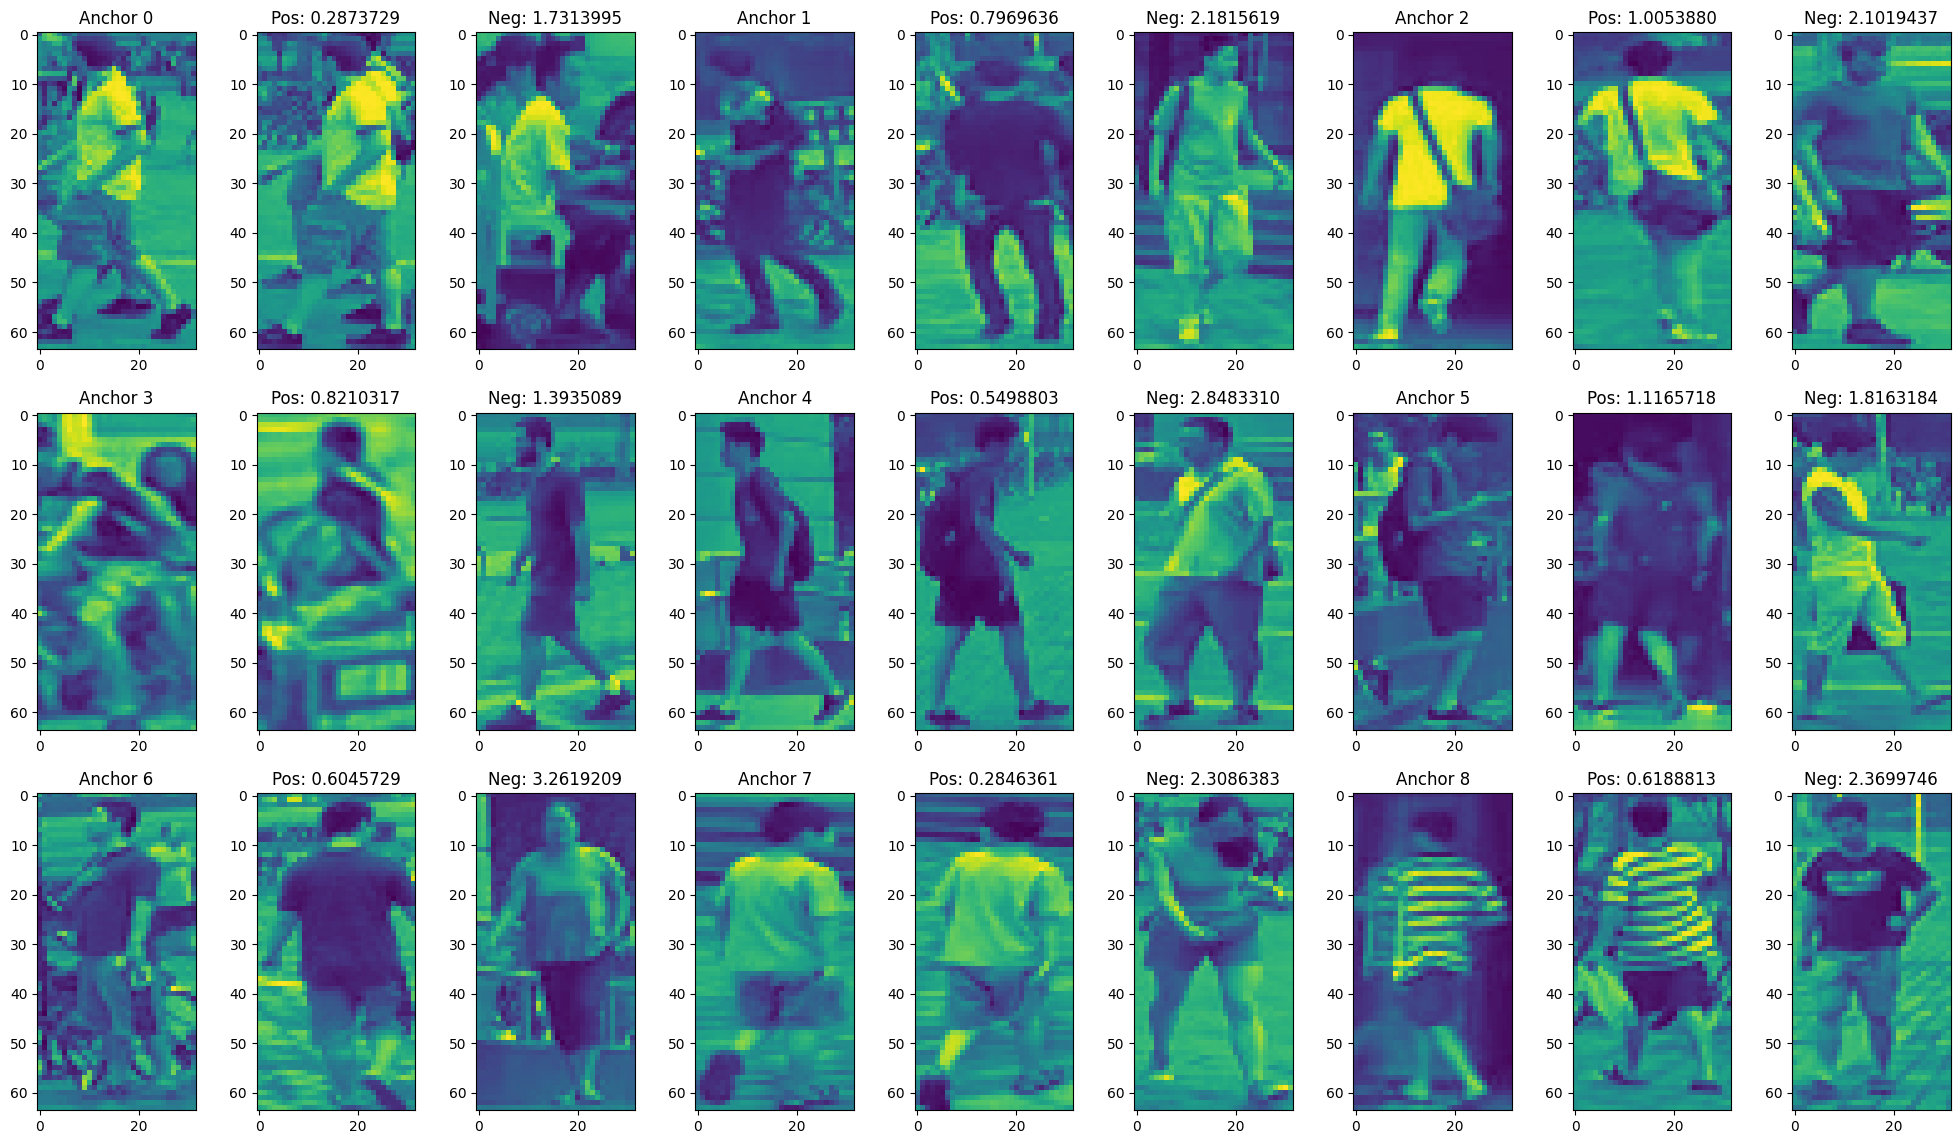

In [20]:
def ComputeDistance(x, y):
    x = normalise_vector(x)
    y = normalise_vector(y)
    dist = keras.ops.sum(keras.ops.square(x - y), axis=-1)
    return dist

x = get_triplet_data(train_X_col_split, train_Y_split, 9)
anchor_embedding = base_network.predict(x[0])
positive_embedding = base_network.predict(x[1])
negative_embedding = base_network.predict(x[2])
pos_dists = ComputeDistance(anchor_embedding, positive_embedding)
neg_dists = ComputeDistance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[25, 14])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Anchor ' + str(i))
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Pos: ' + '%1.7f' % float(pos_dists[i]))
    
    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('Neg: ' + '%1.7f' % float(neg_dists[i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Positive distance: tf.Tensor(1.2190995, shape=(), dtype=float32)
Negative distance: tf.Tensor(1.0322164, shape=(), dtype=float32)
Number of plots: 3


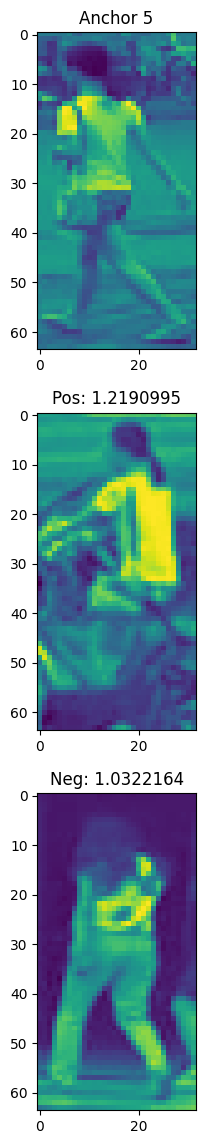

In [77]:
def ComputeDistance(x, y):
    x = normalise_vector(x)
    y = normalise_vector(y)
    dist = keras.ops.sum(keras.ops.square(x - y), axis=-1)
    return dist

x = get_triplet_data(train_X_col_split, train_Y_split, 9)
anchor_embedding = base_network.predict(x[0])
positive_embedding = base_network.predict(x[1])
negative_embedding = base_network.predict(x[2])
pos_dists = ComputeDistance(anchor_embedding, positive_embedding)
neg_dists = ComputeDistance(anchor_embedding, negative_embedding)

# Find indices where positive distance is greater than or equal to negative distance
worst_indices = np.where(pos_dists >= neg_dists)[0]

index = worst_indices[0]  # Get the index of the single image
print("Positive distance:", pos_dists[index])
print("Negative distance:", neg_dists[index])

# Plot only the worst distances
fig = plt.figure(figsize=[25, 14])
for i, index in enumerate(worst_indices):
    ax = fig.add_subplot(3, len(worst_indices), i*3 + 1)
    ax.imshow(x[0][index,:,:,0])
    ax.set_title('Anchor ' + str(index))
    
    ax = fig.add_subplot(3, len(worst_indices), i*3 + 2)
    ax.imshow(x[1][index,:,:,0])    
    ax.set_title('Pos: ' + '%1.7f' % float(pos_dists[index]))
    
    ax = fig.add_subplot(3, len(worst_indices), i*3 + 3)
    ax.imshow(x[2][index,:,:,0])    
    ax.set_title('Neg: ' + '%1.7f' % float(neg_dists[index]))

print("Number of plots:", len(fig.get_axes()))  # Check number of subplots

plt.show()  # Display the plot

In [21]:
incorrect_predictions = []

# Assuming siamese_network.predict returns the predicted labels
predictions = base_network.predict(train_X_col_split)

# Iterate through each prediction and compare with ground truth labels
for i in range(len(predictions)):
    predicted_label = predictions[i]
    print(predicted_label)
    true_label = train_Y_split[i]
    
    # Check if any element in the predicted label array is different from the corresponding true label
    if not np.array_equal(predicted_label, true_label):
        incorrect_predictions.append((train_X_col_split[i], predicted_label, true_label))
    
    # Break the loop when you have found the first 20 incorrect predictions
    if len(incorrect_predictions) == 20:
        break

# Print or process the incorrect predictions
for i, (incorrect_sample, predicted_label, true_label) in enumerate(incorrect_predictions):
    print(f"Incorrect Prediction {i+1}:")
    print(f"Predicted Label: {predicted_label}, True Label: {true_label}")
    # You can also display the incorrect samples if needed

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[-0.2818017  -0.33168966  0.81009966  0.27903244 -0.73861104 -0.24179073
  0.2920467   1.4339691   1.1102368   0.25040227  1.1794276  -2.7509923
 -0.63141674  0.6457877   1.585915    1.2291394   0.30034262 -0.3525569
  0.9677199  -0.10358059  0.13509029  0.11309015 -1.0618747   1.8363822
  1.8707805  -1.121313    2.9330747   0.11812992 -0.67256194  2.0335734
 -0.40054613 -0.18410516]
[ 0.5397852  -0.27901387  0.25566778 -1.1112067  -0.8609111  -0.3515604
 -1.4764458  -0.06247306  0.3210779   0.4548994   1.3367023   0.69429964
 -0.44182992  0.20170939 -0.0706608   0.21338117 -0.8957163   0.02116165
  0.04878172  1.3590456   0.42442483 -1.014823    0.06299891 -2.0588996
  0.03598216  0.76911217  0.03750648  0.45939508  0.3178325   0.37860835
  1.2306683   0.24979582]
[-0.03848931  0.8991486  -1.004437    1.4498171  -0.45049006 -0.23187977
 -0.58357996 -0.8773699  -0.73869574  0.06086844 -0.25463653 -0.30098304
 -0.5242848  -0.42362434  1.171422   

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(fill_mode = 'nearest')
train_data = train_gen.flow(x = train_X_col_split, y = train_Y_split, batch_size = 32)

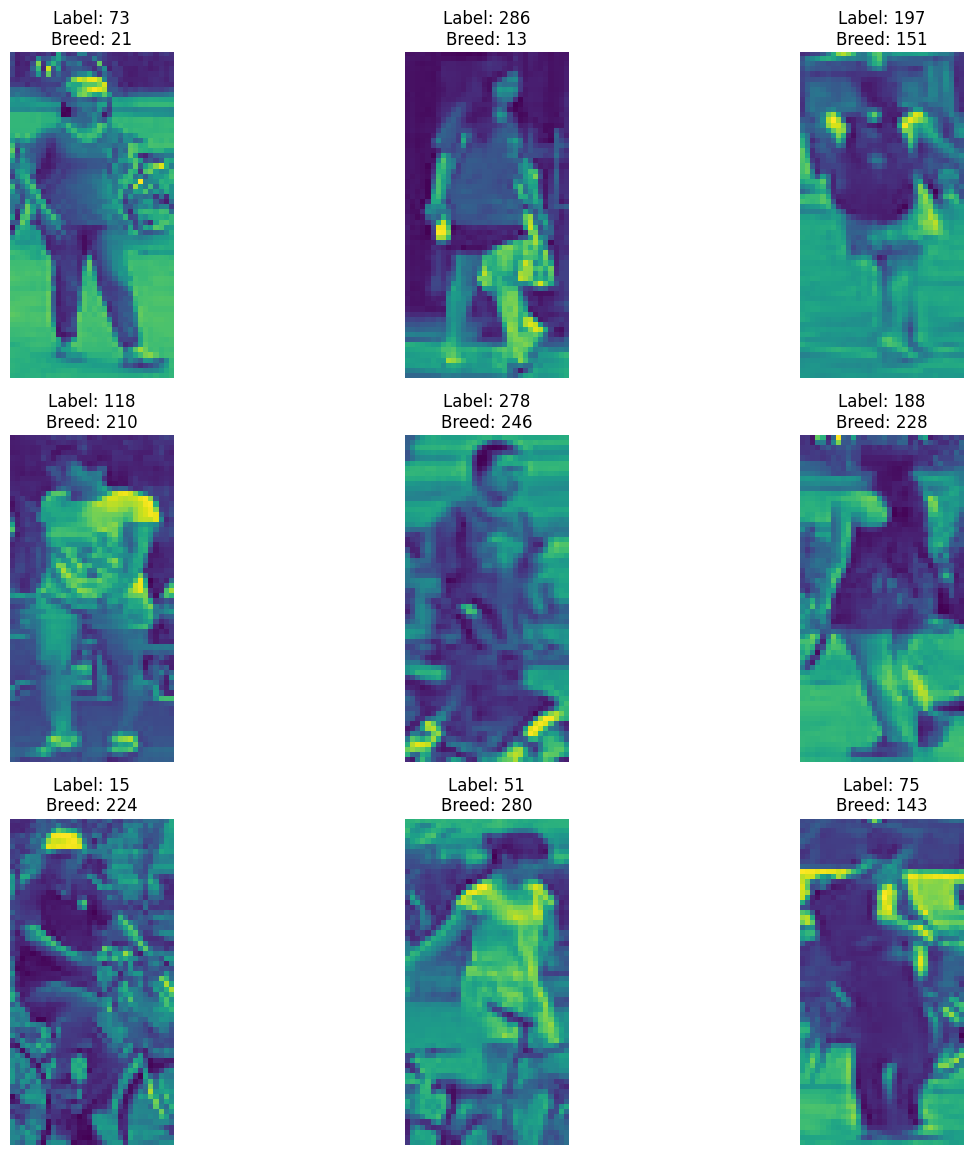

In [47]:
def plot_generator_images(gen, suptitle, labelDecDict, print_pred=False, model=None, nrows=3, ncols=3, figsize=(12, 12)):
    gen_data = next(gen)
    
    plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2)
    
    if print_pred and model:
        pred = np.argmax(base_network.predict(gen_data[0]), axis=1)

    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i + 1)
        plt.axis(False)
        plt.grid(False)
        
        if print_pred and pred.any():
            plt.title(f"True: {labelDecDict[gen_data[1][i]]}\nPredicted: {labelDecDict[pred[i]]}")
        else:
            plt.title(f'Label: {gen_data[1][i]}\nBreed: {labelDecDict[gen_data[1][i]]}')
        plt.imshow(gen_data[0][i])

plot_generator_images(train_data, "Training data", train_Y_split)

AttributeError: 'numpy.ndarray' object has no attribute 'next'

In [23]:
reconstructed_1 = transformed_train_data[:,0:3].dot(pca_model.components_[0:3,:]) + pca_model.mean_

print(reconstructed_1[1:6,:])
print(train_X_vec[1:6,:])
print('\nError: %f' % (np.square(train_X_vec - reconstructed_1)).mean(axis=None))

[[ 0.75531834  0.7497719   0.7602777  ...  0.5683604   0.61853343
   0.62393165]
 [ 0.10106737  0.11259147  0.10977316 ... -0.0558888  -0.05303974
  -0.04977005]
 [-0.04232177 -0.04251702 -0.05446859 ...  1.1169336   1.1741394
   1.177437  ]
 [ 0.35969478  0.35161728  0.3620745  ... -0.02585861 -0.0188379
  -0.01854657]
 [ 0.25403893  0.25416347  0.26046973 ... -0.17294605 -0.17463963
  -0.17352134]]
[[-0.22906144 -1.0886861  -0.00749059 ...  1.6441553   1.6499364
   1.6109856 ]
 [ 0.10343684  1.660713    0.9654529  ... -0.53328514 -0.40652838
  -0.26024005]
 [-0.11917797 -0.43035465 -0.7029599  ...  0.5790341   0.39686736
   0.4674438 ]
 [-0.5889513  -0.61696297 -0.500446   ... -0.5955174  -0.6421823
  -0.8953858 ]
 [ 1.3385079   1.9169105   0.7658308  ... -1.6972551  -0.9012145
  -0.5041216 ]]

Error: 0.654487


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Top-1 Accuracty: 0.15282392026578073
Top-2 Accuracty: 0.2425249169435216
Top-3 Accuracty: 0.3023255813953488
Top-4 Accuracty: 0.34551495016611294
Top-5 Accuracty: 0.3754152823920266
Top-6 Accuracty: 0.4186046511627907
Top-7 Accuracty: 0.4318936877076412
Top-8 Accuracty: 0.45514950166112955
Top-9 Accuracty: 0.4584717607973422
Top-10 Accuracty: 0.4883720930232558


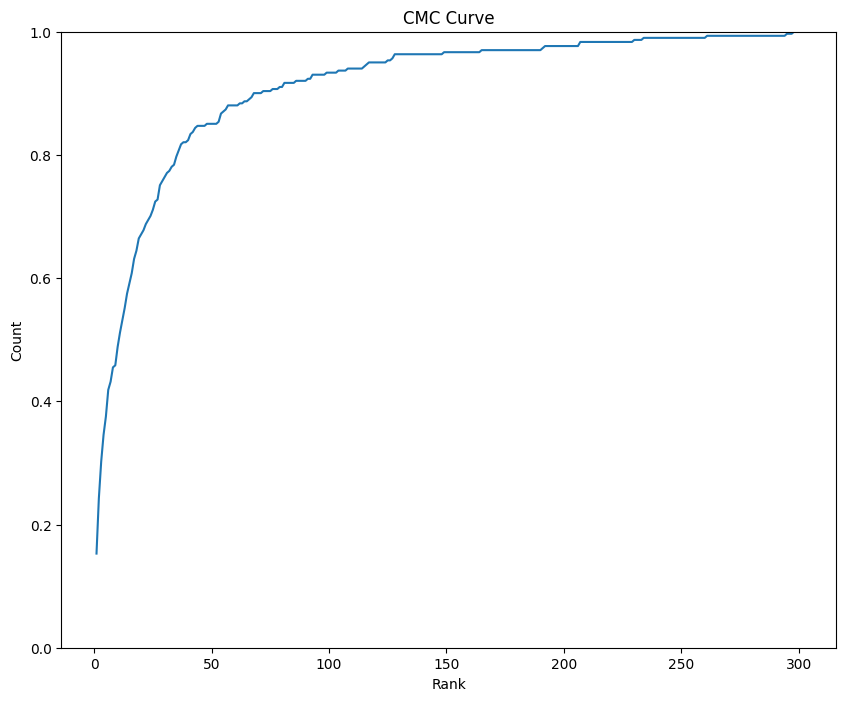

In [24]:
# Get features for gallery samples
gallery_features = base_network.predict(gallery_X_col)

# Get features for probe samples
probe_features = base_network.predict(probe_X_col)

ranked_hist = get_ranked_histogram_l1_distance(gallery_features, gallery_Y, probe_features, probe_Y)

cmc_curve = ranked_hist_to_CMC(ranked_hist)

print("Top-1 Accuracty:",cmc_curve[0]) 
print("Top-2 Accuracty:",cmc_curve[1])
print("Top-3 Accuracty:",cmc_curve[2])
print("Top-4 Accuracty:",cmc_curve[3])
print("Top-5 Accuracty:",cmc_curve[4])
print("Top-6 Accuracty:",cmc_curve[5])
print("Top-7 Accuracty:",cmc_curve[6])
print("Top-8 Accuracty:",cmc_curve[7])
print("Top-9 Accuracty:",cmc_curve[8])
print("Top-10 Accuracty:",cmc_curve[9]) 

plot_cmc(cmc_curve)

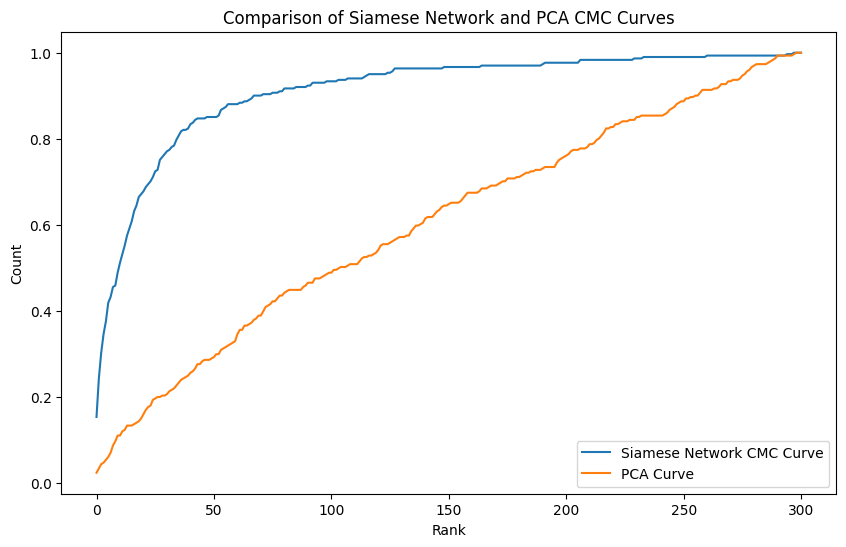

In [25]:
plt.figure(figsize=(10, 6))

# Plot Siamese network CMC curve
plt.plot(cmc_curve, label='Siamese Network CMC Curve')

# Plot PCA curve
plt.plot(cmc_curve_pca, label='PCA Curve')

plt.xlabel('Rank')
plt.ylabel('Count')
plt.title('Comparison of Siamese Network and PCA CMC Curves')
plt.legend()

plt.show()

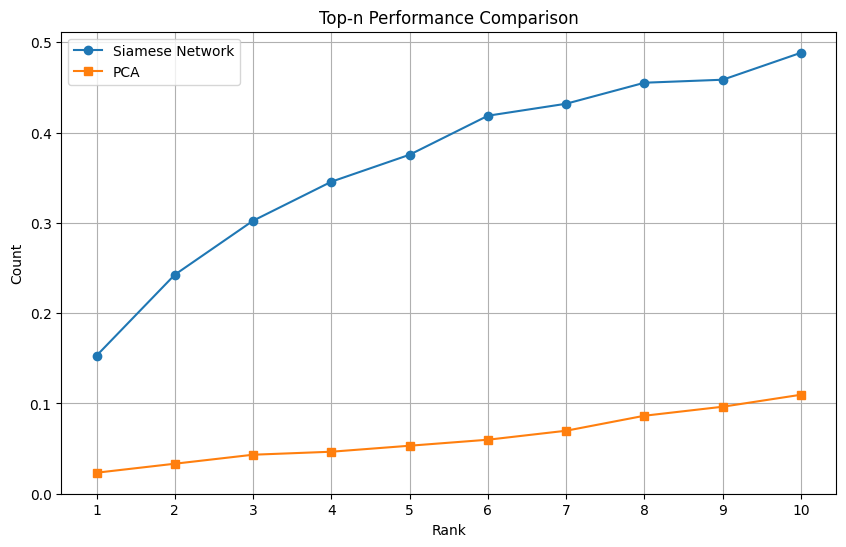

In [26]:
# Define the value of n for top-n performance
n = 10  # Change this value as needed

# Get the identification rates for the top-n ranks
siamese_top_n = cmc_curve[:n]
pca_top_n = cmc_curve_pca[:n]

# Define the ranks for plotting
ranks = np.arange(1, n + 1)

# Create a bar plot
plt.figure(figsize=(10, 6))

plt.plot(ranks, siamese_top_n, marker='o', label='Siamese Network')
plt.plot(ranks, pca_top_n, marker='s', label='PCA')

plt.xlabel('Rank')
plt.ylabel('Count')
plt.title('Top-n Performance Comparison')
plt.xticks(ranks)
plt.grid(True)
plt.legend()

plt.show()


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


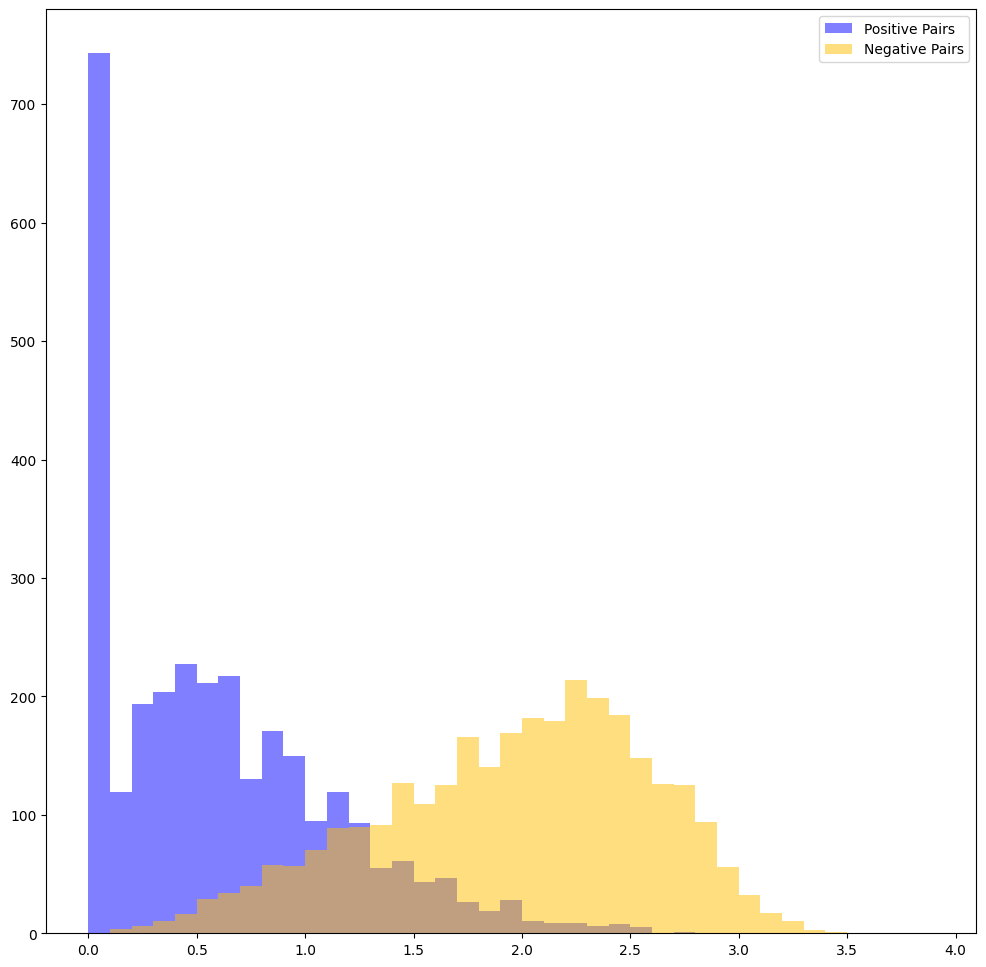

In [27]:
anchor_embedding = base_network.predict(triplet_test_x[0])
positive_embedding = base_network.predict(triplet_test_x[1])
negative_embedding = base_network.predict(triplet_test_x[2])

positive_distances = ComputeDistance(anchor_embedding, positive_embedding)
negative_distances = ComputeDistance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.hist(positive_distances, np.arange(0, 4.0, 0.1), label='Positive Pairs', fc=(0, 0, 1.0, 0.5))
ax.hist(negative_distances, np.arange(0, 4.0, 0.1), label='Negative Pairs', fc=(1.0, 0.75, 0, 0.5))
ax.legend();

In [28]:
# 
# Evaluation
# 
# You will now evaluate your methods using the CMC curve and rank-1, -5 and -10 accuracies. The functions provided above will allow
# you to obtain these values. To do this you will use code that is something like the following:
#
# gallery_feats = model.transform(gallery_X)
# probe_feats = model.transform(probe_X)
# ranked_hist = get_ranked_histogram_l1_distance(gallery_feats, gallery_Y, probe_feats, probe_Y)
# cmc = ranked_hist_to_CMC(ranked_hist)
# rank_1_acc = cmc[0]
# rank_5_acc = cmc[4]
# rank_10_acc = cmc[9]
# plot_cmc(cmc)
#
# In the above, the model.transform operation will be replaced with whatever is appropriate for what you have done. For the non-DL
# method, this is likely to be fairly similar. For the DL method, you will likely change this to call the predict function on your
# backbone network. Your input data (gallery_X and probe_X) will also change to any resized, colour converted and/or vectorised
# version you are using.
#
# The cmc variable that results from the call to ranked_hist_to_CMC will give you the rank-1, -5 and -10 accuracies directly, and
# is what you will plot to visualise performance. Note that you may wish to plot the CMCs for both models on the same axis to make
# it easier to compare performance.
# 

In [29]:
# For your write-up, you should include:
# - briefly mention any pre-processing you did and why; or why you left the data as-is. Note that for fair comparison, 
#   use the same pre-processing for both the methods (non-deep learning and deep-learning) is recommended. If you split 
#   the data into training and validation sets you could dicsuss this here too
# - Outline your methods. For both the non-DL and DL methods, outline what you did and why, and any key parameters you
#   set. For the DL method, outline how it was trained.
# - An evaluation, that covers the Rank-1, -5 and -10 results, and the CMC curves. Consider where performance differs
#   between the models, and the pros and cons of each.
# - A brief discsusion of the ethical considerations as they relate to person re-id (see the assignment brief for 
#   further details and references to use as a starting point
# Your write-up should be supported by appropriate figures and tables. Figures and tables should have numbers and meaningful captions
#
# SEE THE ASSIGNMENT BRIEF ON CANVAS FOR MORE DETAILS AND NOTE THAT A NOTEBOOK FILE DOES NOT CONSTITUTE A VALID SUBMISSION. 
# YOU SHOULD WRITE UP YOUR RESPONSE IN A SEPARATE DOCUMENT